In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [ ]:
from google.colab import files 
upload = files.upload()

Saving data_nlp.csv to data_nlp.csv


In [ ]:
data = pd.read_csv('data_nlp.csv')
# Keeping only the neccessary columns
data = data[['ID','kategori','isi_laporan','sentimen']]
data

,ID,kategori,isi_laporan,sentimen
0,1,Fisik,Saya anak broken home. Sekarang saya tinggal b...,Low
1,2,Fisik,Ayah selalu memukuli saya dan ibu jika mabuk. ...,Low
2,3,Fisik,Biasanya ibu akan mukul kalau aku ngga berhasi...,Low
3,4,Fisik,"Kemarin saya bertengkar dengan suami, dia menj...",Low
4,5,Fisik,Sering sekali saya lihat ibu-ibu pengemis deng...,Low
...,...,...,...,...
495,496,penelantaran,Pagi tadi di jalanan X saya melihat anak yang ...,Low
496,497,penelantaran,malam ini saat saya mendengar suara tangis seo...,High
497,498,penelantaran,Anak dari bapak x yang suka minum minuman kera...,High
498,499,penelantaran,waktu itu saya mendengar ada suara tangisan ba...,Low


In [ ]:
data.isnull().sum()

ID             0
kategori       0
isi_laporan    0
sentimen       0
dtype: int64

In [ ]:
data = data[data.sentimen != "Medium"]

data['isi_laporan'] = data['isi_laporan'].apply(lambda x: x.lower())
data['isi_laporan'] = data['isi_laporan'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    
# for idx,row in data.iterrows():
#     row[0] = row[0].replace('rt',' ')
    
data.head()

,ID,kategori,isi_laporan,sentimen
0,1,Fisik,saya anak broken home sekarang saya tinggal be...,Low
1,2,Fisik,ayah selalu memukuli saya dan ibu jika mabuk i...,Low
2,3,Fisik,biasanya ibu akan mukul kalau aku ngga berhasi...,Low
3,4,Fisik,kemarin saya bertengkar dengan suami dia menja...,Low
4,5,Fisik,sering sekali saya lihat ibuibu pengemis denga...,Low


In [ ]:
print(len(data[data.sentimen == "High"]))
print(len(data[data.sentimen == "Low"]))

253
247


In [ ]:
max_features = 3000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['isi_laporan'].values)
X = tokenizer.texts_to_sequences(data['isi_laporan'].values)
X = pad_sequences(X)

In [ ]:
Y = pd.get_dummies(data['sentimen']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(400, 53) (400, 2)
(100, 53) (100, 2)


In [ ]:
kategori = pd.get_dummies(data.sentimen)
data = pd.concat([data, kategori], axis=1 )
data = data.drop(columns=['ID', 'kategori','sentimen'])
data

,isi_laporan,High,Low
0,saya anak broken home sekarang saya tinggal be...,0,1
1,ayah selalu memukuli saya dan ibu jika mabuk i...,0,1
2,biasanya ibu akan mukul kalau aku ngga berhasi...,0,1
3,kemarin saya bertengkar dengan suami dia menja...,0,1
4,sering sekali saya lihat ibuibu pengemis denga...,0,1
...,...,...,...
495,pagi tadi di jalanan x saya melihat anak yang ...,0,1
496,malam ini saat saya mendengar suara tangis seo...,1,0
497,anak dari bapak x yang suka minum minuman kera...,1,0
498,waktu itu saya mendengar ada suara tangisan ba...,0,1


In [ ]:
y_train = to_categorical(Y_train, 2)
y_test = to_categorical(Y_test, 2)

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D (0.25))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 128)           384000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 53, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 639,194
Trainable params: 639,194
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, 
                    epochs = 15, 
                    batch_size=batch_size, 
                    validation_data=(X_test, Y_test),
                    verbose = 1)

Epoch 1/15
13/13 [==============================] - 23s 276ms/step - loss: 0.6934 - accuracy: 0.4786 - val_loss: 0.6955 - val_accuracy: 0.4600
Epoch 2/15
13/13 [==============================] - 3s 201ms/step - loss: 0.6855 - accuracy: 0.5608 - val_loss: 0.6983 - val_accuracy: 0.4400
Epoch 3/15
13/13 [==============================] - 3s 212ms/step - loss: 0.6724 - accuracy: 0.7322 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 4/15
13/13 [==============================] - 3s 201ms/step - loss: 0.5776 - accuracy: 0.7859 - val_loss: 0.7075 - val_accuracy: 0.5100
Epoch 5/15
13/13 [==============================] - 3s 208ms/step - loss: 0.4627 - accuracy: 0.8909 - val_loss: 0.7985 - val_accuracy: 0.5300
Epoch 6/15
13/13 [==============================] - 3s 203ms/step - loss: 0.2997 - accuracy: 0.8946 - val_loss: 0.8374 - val_accuracy: 0.5700
Epoch 7/15
13/13 [==============================] - 3s 202ms/step - loss: 0.2216 - accuracy: 0.9238 - val_loss: 1.2082 - val_accuracy: 0.4900
Epoch

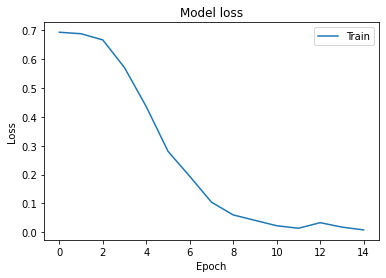

In [ ]:
import matplotlib.pyplot as plt

#melakukan plot untuk model loss pada training data 

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

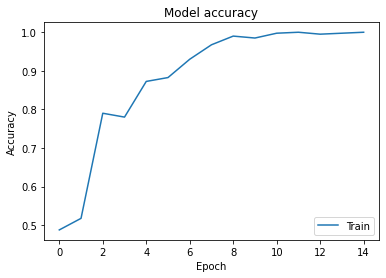

In [ ]:
#melakukan plot untuk model accuracy pada training data 

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [ ]:
import tensorflow as tf 

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
model.fit(X_train, Y_train, epochs=15, callbacks=[callbacks])

Epoch 1/15
13/13 [==============================] - 3s 210ms/step - loss: 0.0068 - accuracy: 1.0000

Akurasi telah mencapai >90%!


In [ ]:
# testing model dengan data laporan baru yang masuk
laporan_baru = ["saya berusia 8 tahun tinggal bersama ibu tiri saya. ketika melakukan kesalahan saya dicubit dan dipukul dengan menggunakan sapu lidi. Tolong saya lepas dari siksaan ibu tiri saya"]
testing = tokenizer.texts_to_sequences(laporan_baru)
data_testing = pad_sequences(testing, maxlen=20)
prediksi = model.predict(data_testing)
print("Hasil prediksi {}".format(prediksi))

Hasil prediksi [[0.856198   0.14380197]]


In [ ]:
import json
json.dumps(tokenizer.word_index)

'{"saya": 1, "dan": 2, "di": 3, "anak": 4, "sering": 5, "tidak": 6, "oleh": 7, "dengan": 8, "yang": 9, "dia": 10, "aku": 11, "ibu": 12, "karena": 13, "untuk": 14, "rumah": 15, "tetangga": 16, "sangat": 17, "suami": 18, "suka": 19, "sekolah": 20, "ke": 21, "melakukan": 22, "saat": 23, "pada": 24, "ayah": 25, "tapi": 26, "ada": 27, "sekarang": 28, "orang": 29, "ini": 30, "ingin": 31, "teman": 32, "jika": 33, "mereka": 34, "kekerasan": 35, "pernah": 36, "sudah": 37, "mau": 38, "ia": 39, "x": 40, "diperkosa": 41, "pulang": 42, "setiap": 43, "dari": 44, "masih": 45, "kemarin": 46, "itu": 47, "hingga": 48, "adik": 49, "dalam": 50, "sedang": 51, "hari": 52, "kalau": 53, "akan": 54, "sama": 55, "melihat": 56, "ketika": 57, "padahal": 58, "ternyata": 59, "anaknya": 60, "trauma": 61, "seorang": 62, "kasar": 63, "juga": 64, "fisik": 65, "selalu": 66, "banget": 67, "merasa": 68, "kakak": 69, "dipaksa": 70, "sakit": 71, "tolong": 72, "melaporkan": 73, "bisa": 74, "pergi": 75, "depan": 76, "takut": 

In [ ]:
pip install tensorflowjs

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 112kB 10.3MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'models')